In [96]:
%run correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/eggNOG/

/work/clusterEvo/new_tests/eggNOG


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
from scipy.spatial.distance import braycurtis
import igraph as ig
from Bio import SeqIO
import requests

In [3]:
single_copy = pd.read_csv('single_copy_genes.tsv', sep='\t', index_col=0)
single_copy.head()

,group_id,num_proteins,num_taxa,members,taxa
1277,arCOG00079,112,112,"1041930.Mtc_1976,1054217.TALC_01539,1070774.J0...","[1041930, 1054217, 1070774, 1071085, 1094980, ..."
1279,arCOG00081,166,166,"1006006.Mcup_0318,1033806.HTIA_0777,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1519,arCOG00354,112,112,"1033806.HTIA_1426,1041930.Mtc_0671,1042877.GQS...","[1033806, 1041930, 1042877, 1070774, 1071085, ..."
1520,arCOG00355,106,106,"1033806.HTIA_0952,1041930.Mtc_0275,1042877.GQS...","[1033806, 1041930, 1042877, 1070774, 1071085, ..."
1561,arCOG00410,168,168,"1006006.Mcup_0164,1033806.HTIA_1385,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."


In [4]:
eggNOG_trees = pd.read_csv('2157_trees.tsv',
                           sep      ='\t',
                           header   =None,
                           usecols  =[1,2,3],
                           index_col=0,
                           names    =['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=single_copy.group_id)

In [202]:
group_ids = []
trees     = []
for index, row in eggNOG_trees.iterrows():
    group_ids.append(index)
    trees.append(ete3.Tree(row.tree))

pool          = multiprocessing.Pool(processes = 10)
dist_matrices = pool.map(get_matrix_from_tree, trees)

table = {group:matrix for group, matrix in zip(group_ids, dist_matrices)}

In [102]:
def run_coevol(matrices):
    m1 = matrices[0].copy()
    m2 = matrices[1].copy()
    return(assess_coevolution(m1, m2, gene_sep='.')[1])

matrix1 = dist_matrices[0].copy()
matrix2 = dist_matrices[1].copy()
run_coevol((matrix1, matrix2))

0.8713248922984702

In [203]:
pool   = multiprocessing.Pool(processes=10)
odr_r2 = pool.map(run_coevol, itertools.combinations(dist_matrices, 2))

In [204]:
group1, group2 = [], []
for n, m in itertools.combinations(group_ids, 2):
    group1.append(n)
    group2.append(m)

In [205]:
odr_df = pd.DataFrame(columns=['group1', 'group2', 'Rsquared'],
                      data   =zip(group1,
                                  group2,
                                  odr_r2))
odr_df.to_parquet('odr_regression_Rsquared.parquet')

In [206]:
def get_braycurtis(pair):
    (index1, row1), (index2, row2) = pair

    taxa1 = re.findall('(?:^|,)(\d+)', row1.members)
    taxa2 = re.findall('(?:^|,)(\d+)', row2.members)

    freq1 = Counter(taxa1)
    freq2 = Counter(taxa2)

    freq1_input = []
    freq2_input = []
    for taxon in set(taxa1).union(taxa2):
        if taxon in freq1:
            freq1_input.append(freq1[taxon])
        else:
            freq1_input.append(0)
        if taxon in freq2:
            freq2_input.append(freq2[taxon])
        else:
            freq2_input.append(0)    
            
    return(row1.group_id, 
           row2.group_id, 
           1 - braycurtis(freq1_input, freq2_input))

pool               = multiprocessing.Pool(processes=10)
braycurtis_indices = pool.map(get_braycurtis, 
                              itertools.combinations(single_copy.iterrows(), 2))

In [207]:
braycurtis_df = pd.DataFrame(columns=['group1', 'group2', 'braycurtis'],
                             data   =braycurtis_indices)
braycurtis_df.to_parquet('braycurtis_indices.parquet')

In [208]:
# odr_df['jaccard_product']   = odr_df.Rsquared * jaccard_df.jaccard
odr_df['Rsquared_corrected']= odr_df.Rsquared * braycurtis_df.braycurtis

In [20]:
geo_matrix = pd.read_csv('geodesic_distances.csv', index_col=0)
geo_matrix = geo_matrix.reindex(index  =group_ids,
                                columns=group_ids)
rf_matrix  = pd.read_csv('rf_distances.csv',       index_col=0)
rf_matrix  = rf_matrix.reindex(index  =group_ids,
                               columns=group_ids)

triu_indices           = np.triu_indices_from(geo_matrix, k=1)
geo_edges              = pd.DataFrame()
geo_edges['group1']    = geo_matrix.index[ triu_indices[0]]
geo_edges['group2']    = geo_matrix.index[ triu_indices[1]]
geo_edges['geodesic' ] = 1/geo_matrix.values[triu_indices]

triu_indices       = np.triu_indices_from(rf_matrix, k=1)
rf_edges           = pd.DataFrame()
rf_edges['group1'] = rf_matrix.index[ triu_indices[0]]
rf_edges['group2'] = rf_matrix.index[ triu_indices[1]]
rf_edges['rf' ]    = 1/rf_matrix.values[triu_indices]

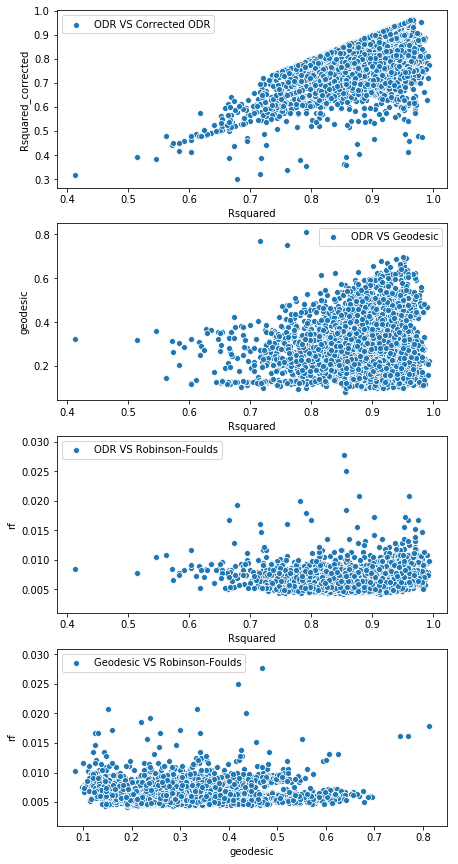

In [230]:
fig, axs = plt.subplots(nrows=4, figsize=(7, 15))

sns.scatterplot(odr_df.Rsquared,
                odr_df.Rsquared_corrected,
                ax   =axs[0],
                label='ODR VS Corrected ODR')

sns.scatterplot(odr_df.Rsquared,
                geo_edges.geodesic,
                ax   =axs[1],
                label='ODR VS Geodesic')

sns.scatterplot(odr_df.Rsquared,
                rf_edges.rf,
                ax   =axs[2],
                label='ODR VS Robinson-Foulds')

sns.scatterplot(geo_edges.geodesic,
                rf_edges.rf,
                ax   =axs[3],
                label='Geodesic VS Robinson-Foulds');

In [238]:
string = pd.read_parquet('duplications/few_duplications-string.parquet')

string = string.query('group1 in @single_copy.group_id & '
                      'group2 in @single_copy.group_id').copy()

string['group_pair'] = string[['group1', 'group2']].agg(frozenset, axis=1)
string.drop_duplicates(subset='group_pair', inplace=True)

strongly_related = string.query('combined_score >= 900')
weakly_related   = string.query('combined_score <= 200')

odr_df['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)
geo_edges['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)
rf_edges['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)

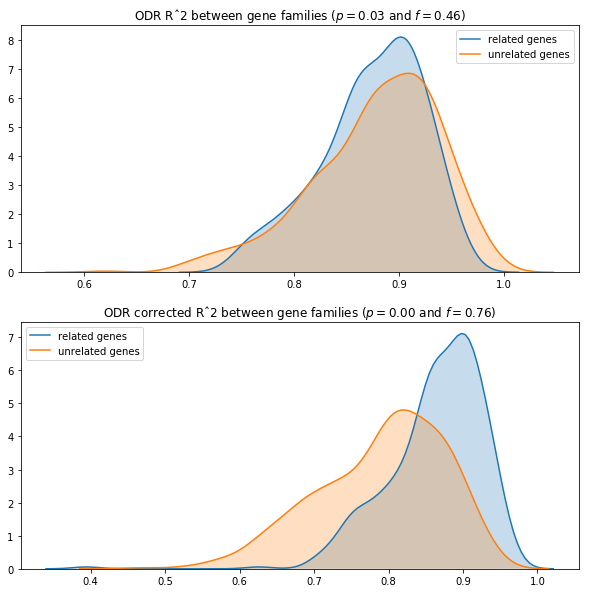

In [247]:
data_columns = ['Rsquared', 'Rsquared_corrected']

fig, axs = plt.subplots(nrows=2, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    strong_odr = odr_df.query('group_pair in @strongly_related.group_pair')[column].values
    weak_odr   = odr_df.query('group_pair in @weakly_related.group_pair'  )[column].values

    hypothesis = mannwhitneyu(weak_odr,
                              strong_odr)
    effect_size = cles(weak_odr, strong_odr)

    sns.kdeplot(strong_odr, shade=True, label='related genes',   ax=ax)
    sns.kdeplot(weak_odr,   shade=True, label='unrelated genes', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'ODR corrected Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

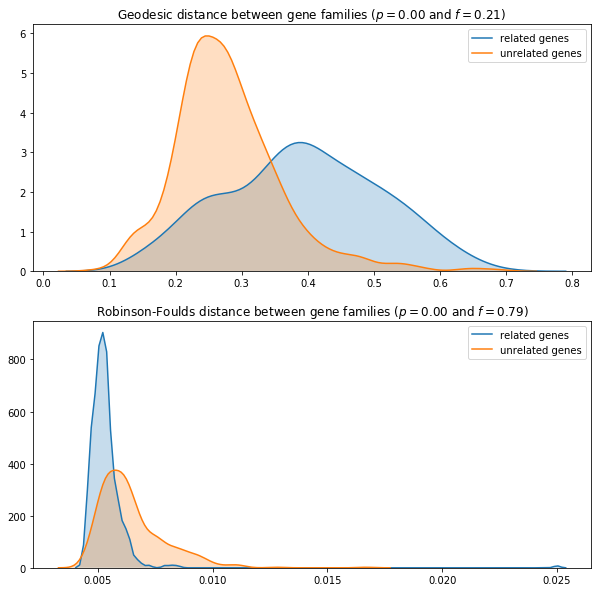

In [255]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
    
neighors_geo     = geo_edges.query('group_pair in @strongly_related.group_pair'    ).geodesic.values
not_neighors_geo = geo_edges.query('group_pair in @weakly_related.group_pair').geodesic.values

hypothesis = mannwhitneyu(neighors_geo,
                          not_neighors_geo)
effect_size = cles(neighors_geo, 
                   not_neighors_geo)

sns.kdeplot(neighors_geo,     shade=True, label='related genes',     ax=axs[0])
sns.kdeplot(not_neighors_geo, shade=True, label='unrelated genes', ax=axs[0])
axs[0].set_title(f'Geodesic distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

neighors_rf     = rf_edges.query('group_pair in @strongly_related.group_pair'    ).rf.values
not_neighors_rf = rf_edges.query('group_pair in @weakly_related.group_pair').rf.values

hypothesis = mannwhitneyu(neighors_rf,
                          not_neighors_rf)
effect_size = cles(neighors_rf, 
                   not_neighors_rf)

sns.kdeplot(neighors_rf,     shade=True, label='related genes',     ax=axs[1])
sns.kdeplot(not_neighors_rf, shade=True, label='unrelated genes', ax=axs[1])
axs[1].set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

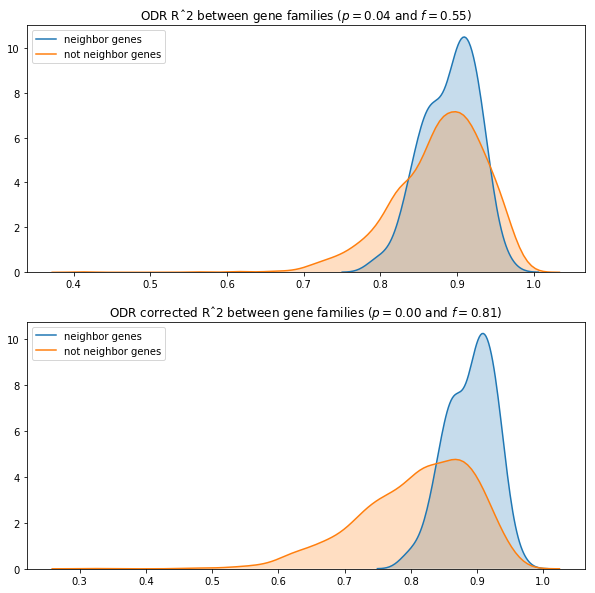

In [246]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    neighors     = string.query('neighborhood >= 700')
    not_neighors = string.query('neighborhood <= 200')

    neighors_odr     = odr_df.query('group_pair in @neighors.group_pair'    )[column].values
    not_neighors_odr = odr_df.query('group_pair in @not_neighors.group_pair')[column].values

    hypothesis = mannwhitneyu(not_neighors_odr,
                              neighors_odr)
    effect_size = cles(not_neighors_odr, neighors_odr)

    sns.kdeplot(neighors_odr, shade=True,     label='neighbor genes',     ax=ax)
    sns.kdeplot(not_neighors_odr, shade=True, label='not neighbor genes', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'ODR corrected Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

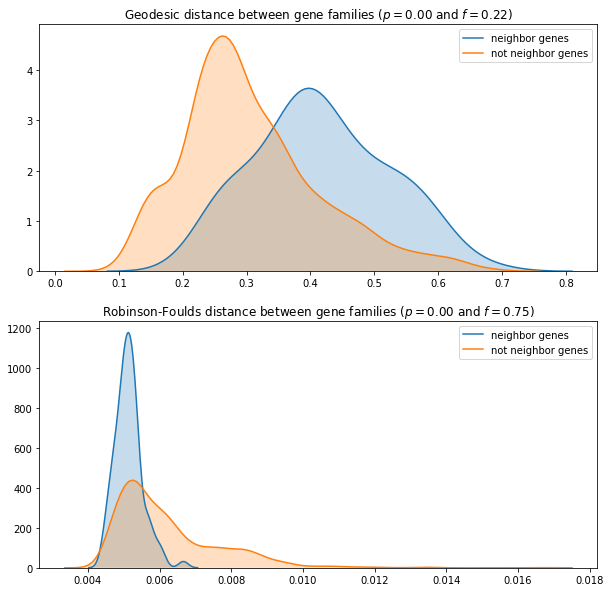

In [254]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
    
neighors_geo     = geo_edges.query('group_pair in @neighors.group_pair'    ).geodesic.values
not_neighors_geo = geo_edges.query('group_pair in @not_neighors.group_pair').geodesic.values

hypothesis = mannwhitneyu(neighors_geo,
                          not_neighors_geo)
effect_size = cles(neighors_geo, 
                   not_neighors_geo)

sns.kdeplot(neighors_geo,     shade=True, label='neighbor genes',     ax=axs[0])
sns.kdeplot(not_neighors_geo, shade=True, label='not neighbor genes', ax=axs[0])
axs[0].set_title(f'Geodesic distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

neighors_rf     = rf_edges.query('group_pair in @neighors.group_pair'    ).rf.values
not_neighors_rf = rf_edges.query('group_pair in @not_neighors.group_pair').rf.values

hypothesis = mannwhitneyu(neighors_rf,
                          not_neighors_rf)
effect_size = cles(neighors_rf, 
                   not_neighors_rf)

sns.kdeplot(neighors_rf,     shade=True, label='neighbor genes',     ax=axs[1])
sns.kdeplot(not_neighors_rf, shade=True, label='not neighbor genes', ax=axs[1])
axs[1].set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [35]:
#
# assemble gene order of reference genomes
#

genome_structures = {}
for filename in os.listdir('reference_genomes/'):
    if not filename.endswith('.gb'):
        continue

    taxid = filename.replace('.gb', '')
    genome_structures[taxid] = []
    
    genbank = SeqIO.parse(f'reference_genomes/{filename}', 'gb')
    for entry in genbank:
        
        locus_tags = []
        for feature in entry.features:
            if feature.type == 'CDS':
                if 'locus_tag' in feature.qualifiers:
                    locus_tags.append(feature.qualifiers['locus_tag'][0])
                else:
                    locus_tags.append('None')

        genome_structures[taxid].append('-'.join(locus_tags))
    
    genome_structures[taxid] = '_-_'.join(genome_structures[taxid])

In [36]:
#
# test adjacency of single copy genes from each reference genome
#

recruited_cds      = {taxid:[] 
                      for taxid in genome_structures.keys()}
locus_tag_to_group = {}
for index, row in single_copy.iterrows():
    
    for taxid in recruited_cds:
        
        if re.search(fr'\b{taxid}\b', row.taxa):
            locus_tag = re.search(f',{taxid}\.([^,]+)', 
                                  row.members).group(1)
            recruited_cds[taxid].append(locus_tag)
            
            locus_tag_to_group[locus_tag] = row.group_id            
            
adjacent_pairs = {}
for taxid, cds_order in genome_structures.items():
    
    adjacent_pairs[taxid] = []
    
    for cds1, cds2 in itertools.combinations(recruited_cds[taxid], 2):
        if re.search(f'({cds1}|{cds2})(-[^-]+){{0,5}}-({cds1}|{cds2})', cds_order):
            adjacent_pairs[taxid].append(frozenset([locus_tag_to_group[cds1], 
                                                    locus_tag_to_group[cds2]]))

distant_pairs = {}
for taxid, cds_order in genome_structures.items():
    
    distant_pairs[taxid] = []
    
    for cds1, cds2 in itertools.combinations(recruited_cds[taxid], 2):
        if re.search(f'({cds1}|{cds2})(-[^-]+){{100,9999}}-({cds1}|{cds2})', cds_order):
            distant_pairs[taxid].append(frozenset([locus_tag_to_group[cds1], 
                                                   locus_tag_to_group[cds2]]))

tmp_distant_pairs = []
for taxid, pairs in distant_pairs.items():
    tmp_distant_pairs.extend(pairs)
distant_frequency = Counter(tmp_distant_pairs)

tmp_adjacent_pairs = []
for taxid, pairs in adjacent_pairs.items():
    tmp_adjacent_pairs.extend(pairs)
adjacency_frequency = Counter(tmp_adjacent_pairs)

In [209]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = odr_df.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.Rsquared)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = odr_df.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.Rsquared)

hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol)
effect_size = cles(distant_genes_coevol, adjacent_genes_coevol)

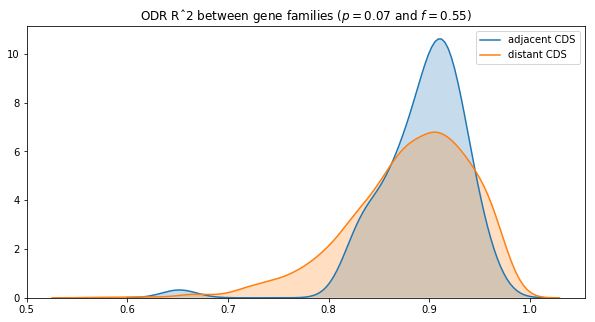

In [210]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [211]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = odr_df.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.Rsquared_corrected)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = odr_df.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.Rsquared_corrected)

hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol)
effect_size = cles(distant_genes_coevol, adjacent_genes_coevol)

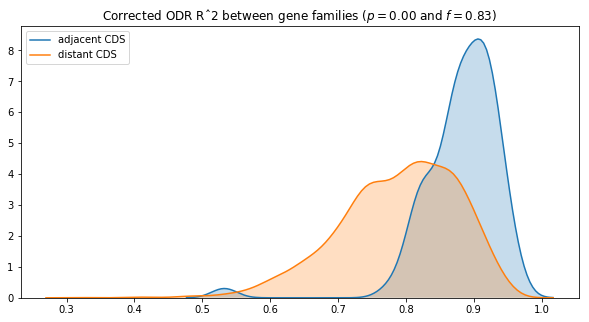

In [212]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'Corrected ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [217]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = geo_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.geodesic)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = geo_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.geodesic)
        
hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol)
effect_size = cles(adjacent_genes_coevol, distant_genes_coevol)

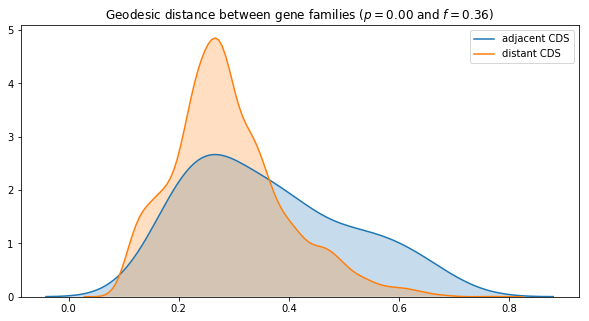

In [218]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'Geodesic distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [219]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = rf_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.rf)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = rf_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.rf)
        
hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol)
effect_size = cles(adjacent_genes_coevol, distant_genes_coevol)

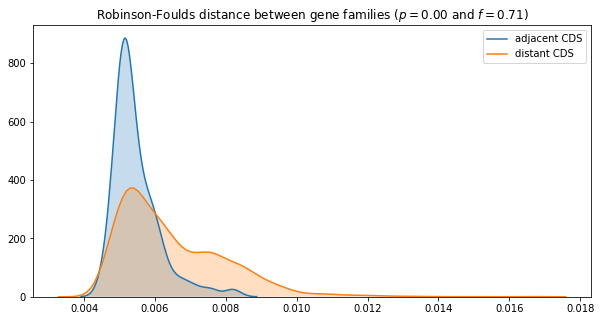

In [220]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [221]:
#
# group functionally related genes
#
combined_related_pairs   = []
combined_unrelated_pairs = []

for taxid, taxon_cds in recruited_cds.items():
    ppi = pd.read_csv(f'reference_genomes/{taxid}.protein.links.v11.0.txt', delim_whitespace=True)

    recruited_ppi = ppi.query(f'(protein1 in {taxon_cds}) & ' 
                              f'(protein2 in {taxon_cds})')
    strong_ppi    = recruited_ppi.query('(combined_score >= 700)')

    related_pairs = set()
    for protein1, protein2 in strong_ppi[['protein1', 
                                          'protein2']].itertuples(index=False, 
                                                                  name=None):
        related_pairs.add( frozenset([locus_tag_to_group[protein1], 
                                      locus_tag_to_group[protein2]]) )

    all_ppi_pairs = set([frozenset([locus_tag_to_group[protein1], 
                                    locus_tag_to_group[protein2]]) 
                         for protein1, protein2 in recruited_ppi[['protein1', 
                                                                  'protein2']].itertuples(index=False, 
                                                                                          name=None)])
    all_possible_pairs = set([frozenset([locus_tag_to_group[protein1], 
                                         locus_tag_to_group[protein2]]) 
                         for protein1, protein2 in itertools.combinations(taxon_cds, 2)])

    unrelated_pairs = all_possible_pairs.difference(all_ppi_pairs)
    
    combined_related_pairs.extend(  related_pairs)
    combined_unrelated_pairs.extend(unrelated_pairs)

related_pairs_frequency   = Counter(combined_related_pairs)
unrelated_pairs_frequency = Counter(combined_unrelated_pairs)

In [222]:
related_genes_coevol = []
for pair, count in related_pairs_frequency.items():
    if count >= 5:
        row = odr_df.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        related_genes_coevol.append(row.Rsquared)

unrelated_genes_coevol = []
for pair, count in unrelated_pairs_frequency.items():
    if count >= 5:
        row = odr_df.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        unrelated_genes_coevol.append(row.Rsquared)
        
hypothesis = mannwhitneyu(related_genes_coevol,
                          unrelated_genes_coevol)
effect_size = cles(unrelated_genes_coevol, related_genes_coevol)

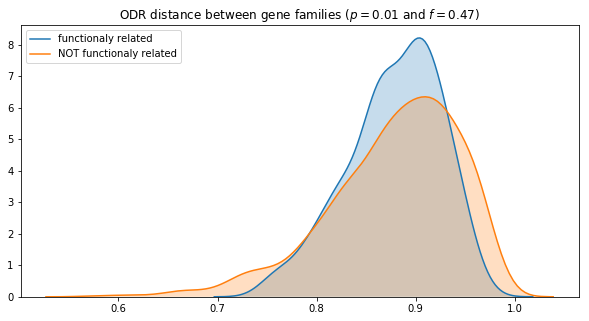

In [223]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(related_genes_coevol,   
            shade=True, 
            label='functionaly related', 
            ax   =ax)
sns.kdeplot(unrelated_genes_coevol, 
            shade=True, 
            label='NOT functionaly related', 
            ax   =ax)

ax.set_title(f'ODR distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [224]:
related_genes_coevol = []
for pair, count in related_pairs_frequency.items():
    if count >= 5:
        row = odr_df.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        related_genes_coevol.append(row.Rsquared_corrected)

unrelated_genes_coevol = []
for pair, count in unrelated_pairs_frequency.items():
    if count >= 5:
        row = odr_df.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        unrelated_genes_coevol.append(row.Rsquared_corrected)
        
hypothesis = mannwhitneyu(related_genes_coevol,
                          unrelated_genes_coevol)
effect_size = cles(unrelated_genes_coevol, related_genes_coevol)

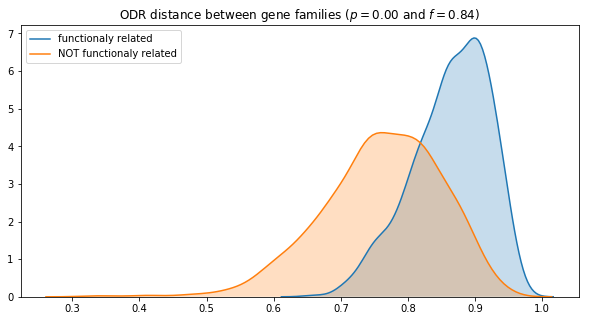

In [225]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(related_genes_coevol,   
            shade=True, 
            label='functionaly related', 
            ax   =ax)
sns.kdeplot(unrelated_genes_coevol, 
            shade=True, 
            label='NOT functionaly related', 
            ax   =ax)

ax.set_title(f'ODR distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [226]:
related_genes_coevol = []
for pair, count in related_pairs_frequency.items():
    if count >= 5:
        row = geo_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        related_genes_coevol.append(row.geodesic)

unrelated_genes_coevol = []
for pair, count in unrelated_pairs_frequency.items():
    if count >= 5:
        row = geo_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        unrelated_genes_coevol.append(row.geodesic)
        
hypothesis = mannwhitneyu(related_genes_coevol,
                          unrelated_genes_coevol)
effect_size = cles(related_genes_coevol, unrelated_genes_coevol)

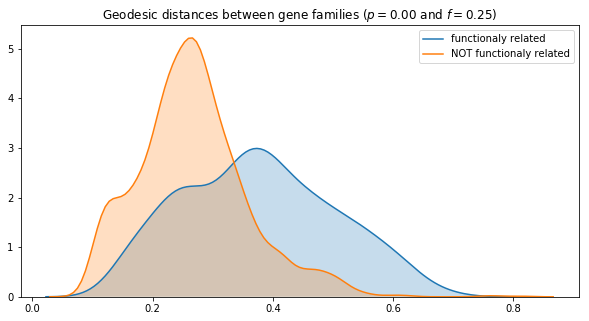

In [227]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(related_genes_coevol,   
            shade=True, 
            label='functionaly related', 
            ax=ax)
sns.kdeplot(unrelated_genes_coevol, 
            shade=True, 
            label='NOT functionaly related', 
            ax=ax)

ax.set_title(f'Geodesic distances between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [228]:
related_genes_coevol = []
for pair, count in related_pairs_frequency.items():
    if count >= 5:
        row = rf_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        related_genes_coevol.append(row.rf)

unrelated_genes_coevol = []
for pair, count in unrelated_pairs_frequency.items():
    if count >= 5:
        row = rf_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        unrelated_genes_coevol.append(row.rf)
        
hypothesis = mannwhitneyu(related_genes_coevol,
                          unrelated_genes_coevol)
effect_size = cles(related_genes_coevol, unrelated_genes_coevol)

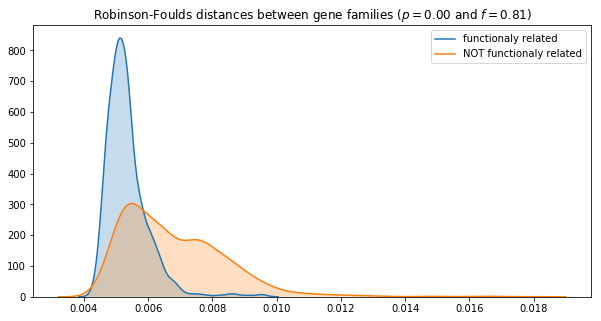

In [229]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(related_genes_coevol,   
            shade=True, 
            label='functionaly related', 
            ax=ax)
sns.kdeplot(unrelated_genes_coevol, 
            shade=True, 
            label='NOT functionaly related', 
            ax=ax)

ax.set_title(f'Robinson-Foulds distances between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');